# Simulate kinetics network equilibration (Fig. S6)

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20231019

This notebook will use deterministic simulations, via numerical integration of ordinary differential equations (ODEs), to estimate the time required for network re-equilibration after a perturbation of the input monomer.

Here, I am going to assume that all coiled-coils have about the same $k_{on}$ rate of $5 \times 10^{5} M^{-1}s^{-1}$ as per [this reference](https://doi.org/10.1021/bi9530604), and that differences in affinity are thus due to differences in $k_{off}$. 

To convert from arbitrary K units to real molecule counts, I will consider 0.001 (unitless), which was our lower concentration limit in the large parameter screen, as 1 molecule. I will consider the volume of a mammalian cell as approximately 3 pL ($10^{-12} L$). 

In [1]:
import os
import sys
import pathlib

import itertools
import numpy as np
import progressbar
import time
import datetime

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
from matplotlib import rcParams

# EQTK to calculate equilibrium concentrations - install instructions here https://eqtk.github.io/getting_started/eqtk_installation.html
import eqtk

# Ray for parallelization - install instructions here https://docs.ray.io/en/latest/ray-overview/installation.html
import ray

# Networkx for graphs - install instructions here https://networkx.org/documentation/stable/install.html
import networkx as nx

ModuleNotFoundError: No module named 'ray'

In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [3]:
# Initialize ray
# _ = ray.init(ignore_reinit_error=True)

In [ ]:
# To shut down ray:
# ray.shutdown()

In [3]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [4]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [5]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


## Define simulation function

In [6]:
def run_eqtk(N, C0, params, num_inputs,num_rxns, acc_monomer_ind):
    """
    Run eqtk.solve given the input stoichiometry matrix (N), initial concentrations (C0), and parameters (params)
    Parameters includes includes Kij values and accessory monomer levels. 
    """
    K = params[:num_rxns]
    C0[:,acc_monomer_ind] = params[num_rxns:]

    return eqtk.solve(c0=C0, N=N, K=K)

In [7]:
def simulate_networks_manual(m, num_inputs, param_sets, t = 12, input_lb = -3, input_ub = 3):
    """
    Run simulations for dimer networks, over a matrix of concentrations for multiple monomers. 
    When >1 monomers are varied (e.g., a 2D matrix), the first monomer is sampled outermost, while the second
    is sampled inner to that.
    
    Parameters
    ----------
    m : int. 
        Number of monomer species. 
    num_inputs: int
        Number of monomers to count as inputs (those titrated). 
        E.g., if num_inputs=2, the first two monomers will be treated as inputs.
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species. log10 scale
    param_sets : array_like shape (num_sets, num_parameters)
        Parameters sets for simulating dimerization networks.  
    Returns
    -------
    C0 : array_like shape (t, number of species)
        Initial concentration array used for eqtk.solve
    S_all : array_like 
        Equlibrium concentration of all species (monomers & dimers)
        for all parameter sets. 
        
    """
    #Create stoichiometry matrix and initial concnetration matrix 
    num_sets = param_sets.shape[0]
    N = make_nXn_stoich_matrix(m)
    num_rxns = N.shape[0]
    M0_min = [input_lb]*num_inputs + [0] * (m-num_inputs)
    M0_max = [input_ub]*num_inputs + [0] * (m-num_inputs)
    num_conc = [t]*num_inputs + [1] * (m-num_inputs)

    C0 = make_C0_grid(m, M0_min=M0_min, M0_max=M0_max, num_conc=num_conc)
        
    acc_monomer_ind = np.arange(num_inputs,m)
    S_all = np.zeros((C0.shape[0], C0.shape[1], num_sets))
    for pset_index, pset in enumerate(param_sets):
        S_all[:,:,pset_index] = run_eqtk(N, C0.copy(), pset, num_inputs, num_rxns,acc_monomer_ind)
    return C0,S_all  

## Define General Constants

In [5]:
# Physical constants
vol_per_cell = 1e-12 # L - estimated for mammalian cell
unitless_conc_per_molecule = 0.001 # Our screen uses concentrations from 0.001 - 1000. We will use a similar range, but consider 0.001 as one molecule per cell.
k_on = 5e5 # M-1 s-1, on rate for binding. This will be the same for every dimerization reaction.
k_on_unitless = k_on/6.0221e23/vol_per_cell # (molecule/cell)-1 s-1, off rate for binding

In [3]:
t = 30 # Number of input points simulated
input_lb = -3 # Lower bound of input concentrations, in log space
input_ub = 3 # Upper bound of input concentrations, in log space
x_points = np.logspace(input_lb,input_ub,t,endpoint=True)

In [4]:
null_K = 1e-10 # Affinity value to use for no binding
K_log_range = [-3,1] # Range of unitless affinity values to test, in log space.
                        # Corresponds to "affinities" of ~100 pM to ~1 μM
A_log_range = [input_lb,input_ub]# Range of accessory  values to test
null_K_homo_fraction=0.25 # Approximate fraction of homodimerization reactions that will not be made possible

## Simulate single case: Generate Parameter Set

In [11]:
m = 8 # Network size

species = make_nXn_species_names(m) # All species in system

dimers = np.array(list(itertools.combinations_with_replacement(range(m),2))) # All dimer combinations

In [12]:
edge_key = {}
homo_edges = []
hetero_edges = []

# Categorize edge types
for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
    edge_key[(combo[0],combo[1])] = i
    if combo[0]==combo[1]:
        homo_edges.append(i)
    else:
        hetero_edges.append(i)

Now generate a parameter set:

In [13]:
min_edges = m - 1
max_edges = num_combos(m,2)
num_edges = 7 # Decide on number of edges to use - minimum m - 1, maximum num_combos(m,2)

param_set = np.concatenate((np.full((num_combos_with_replacement(m,r=2),),null_K),np.ones((m-1,))))
graph = nx.gnm_random_graph(n=m,m=num_edges)
if num_edges<=math.comb(m-1,2):
    # If false, graph is always connected
    while not nx.is_connected(graph):
        graph = nx.gnm_random_graph(n=m,m=num_edges)
edge_indices = [edge_key[x] for x in graph.edges]
# Fill heterodimer K's
rng = np.random.default_rng()
param_set[edge_indices] = 10**rng.uniform(K_log_range[0],K_log_range[1],size=(num_edges,))
# Fill homodimer K's
homo_edges_tofill = rng.choice(homo_edges,size=(round((1-null_K_homo_fraction)*m),),replace=False)
param_set[homo_edges_tofill] = 10**rng.uniform(K_log_range[0],K_log_range[1],size=homo_edges_tofill.shape)
# Fill A's
param_set[-(m-1):] = 10**rng.uniform(A_log_range[0],A_log_range[1],size=(m-1,))

param_sets = np.expand_dims(param_set,axis=0)

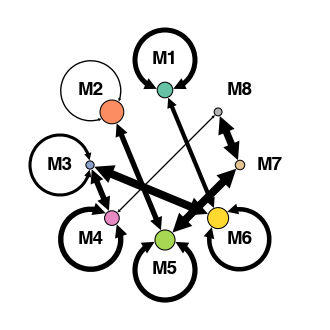

In [18]:
fig, axs = make_network_plots_polygon(m=m, n_input=1,param_sets=np.expand_dims(param_sets[0],axis=0), \
                                        univs_to_plot=np.array([0]),\
                                        ncols = 1,r_node = 0.5, r_loop = 0.2,\
                                        node_scales = [-3,3,4,12], input_node_values=np.array([0 for x in range(1)]),\
                                        K_edge_scales = [-3,1,0.5,4],input_cmap='Set2',\
                                        fontname = 'Helvetica',fontsize=9,non_output_dimer_color='k')

fig.set_dpi(150)

In [19]:
# Convert to more relevant units
K = param_set[:num_combos_with_replacement(m,2)] # Affinities
K_molec = K*unitless_conc_per_molecule # (molecule/cell)-1, affinities in molecule units
k_offs = k_on_unitless/K_molec # s-1, binding off rates, for each dimer

Solve the equilibrium concentrations across an input titration

In [20]:
C0, S_all = simulate_networks_manual(m, num_inputs=1, param_sets=param_sets, t = t, input_lb = -3, input_ub = 3)

Rather than make the initial species amounts all monomers, we're going to use the concentrations at equilibrium for the lowest input value. We're then going to increase the input to the highest value (or vice versa) and see how long it takes to re-equilibrate.

In [22]:
initial_equilibrium_species_concs = S_all[0,:,0] # Dimensionless
initial_equilibrium_species_concs_molec = initial_equilibrium_species_concs/unitless_conc_per_molecule # molecule/cell

# Then re-adjust input concentration
initial_equilibrium_species_concs_molec[0] = x_points[-1]/unitless_conc_per_molecule

dimers = np.array(list(itertools.combinations_with_replacement(range(m),2)))

## Deterministic equilibration (numerical ODE integration), for single case

To perform numerical ODE integration, we need a function that will take our parameters and return the right hand sides of all the relevant ODEs (one for each possible species...)

$\frac{dM_{1}}{dt}=(2k_{off}[D_{11}]-2k_{on}[M_{1}][M_{1}])+
(k_{off}[D_{12}]-k_{on}[M_{1}][M_{2}])+...$ (for all dimers with $M_{1}$)

... etc. for all monomers 

$\frac{dD_{12}}{dt}=k_{on}[M_{1}][M_{2}]-k_{off}[D_{12}]$

... etc. for all dimers

To learn more, see [this page](https://biocircuits.github.io/technical_appendices/02a_numerical_odes.html).

In [28]:
def return_diff_eq_right_sides(current_species_amounts, t, k_on_unitless, k_offs,m,dimers):
    derivatives = []
    for monomer in range(m):
        dimers_with_monomer = [dimer for dimer,monomers in enumerate(dimers) if monomer in monomers]
        stoichiometry=[2 if np.all(np.array(dimers[dimer_i])==monomer) else 1 for dimer_i in dimers_with_monomer]
        derivatives.append(np.sum([(k_offs[dimer]*current_species_amounts[m+dimer]*stoichiometry[i])-\
                                   (k_on_unitless*current_species_amounts[dimers[dimer][0]]*current_species_amounts[dimers[dimer][1]]*stoichiometry[i])\
                                    for i,dimer in enumerate(dimers_with_monomer)]))
    for dimer,monomers in enumerate(dimers):
        derivatives.append((k_on_unitless*current_species_amounts[monomers[0]]*current_species_amounts[monomers[1]])-\
                           (k_offs[dimer]*current_species_amounts[m+dimer]))
    return derivatives

Use this function to solve the kinetics:

In [29]:
time_len = 1000000 # s, total time to simulate for deterministic simulations (testing time to equilibrium)
timepoints = np.linspace(0, time_len, time_len//10, endpoint=True)

In [31]:
solved_kinetics = scipy.integrate.odeint(func=return_diff_eq_right_sides, y0=initial_equilibrium_species_concs_molec, t=timepoints,\
                                args = (k_on_unitless,k_offs,m,dimers)).transpose()

Create a function to check whether all dimers are at equilibrium.

In [32]:
def check_equilibrium(solved_kinetics,eq_concs,tolerance,tolerance_type='abs'):
    '''
    Function to check whether all dimers are at equilibrium following a numerical ODE integration.

    Inputs:
    -------
    solved_kinetics: np.array, shape (m+num_combos_with_replacement(m,2),len(timepoints))
        Array of concentrations of all species over time, as solved by scipy.integrate.odeint
    eq_concs: np.array, shape (m+num_combos_with_replacement(m,2),)
        Array of equilibrium concentrations of all species, as solved by simulate_networks_manual
    tolerance_type: str, 'abs' or 'rel' (default 'abs')
        If 'abs': tolerance is the maximum absolute difference between the known equilibrium value and the numerical solution
        If 'rel': tolerance is the maximum ratio between the known equilibrium value and the numerical solution. 
            For example, tolerance=0.1 if all species must be within 10% of the equilibrium value.
    
    Returns:
    --------
    bool: True if all species are within tolerance of the equilibrium value
    '''
    if tolerance_type=='abs':
        return np.all([np.abs(eq_concs[species]-solved_kinetics[species,-1])<=tolerance \
                       for species in range(m+num_combos_with_replacement(m,2))])
    elif tolerance_type=='rel':
        max_allowed_ratio = 1+tolerance
        min_allowed_ratio = max(0,1-tolerance)
        return np.all([(((np.abs(eq_concs[species]-solved_kinetics[species,-1])/eq_concs[species])<=max_allowed_ratio) and\
                        ((np.abs(eq_concs[species]-solved_kinetics[species,-1])/eq_concs[species])>=min_allowed_ratio))\
                       for species in range(m+num_combos_with_replacement(m,2))])

In [34]:
eq_concs=S_all[-1,:,0]/unitless_conc_per_molecule

In [35]:
check_equilibrium(solved_kinetics=solved_kinetics,eq_concs=eq_concs,\
                  tolerance=1,tolerance_type='abs')

True

Plot:


In [37]:
points_to_plot = 1000 # Number of points to sample and plot (plotting every point is slow)

species_to_plot = make_nXn_species_names(m).index('M_7')

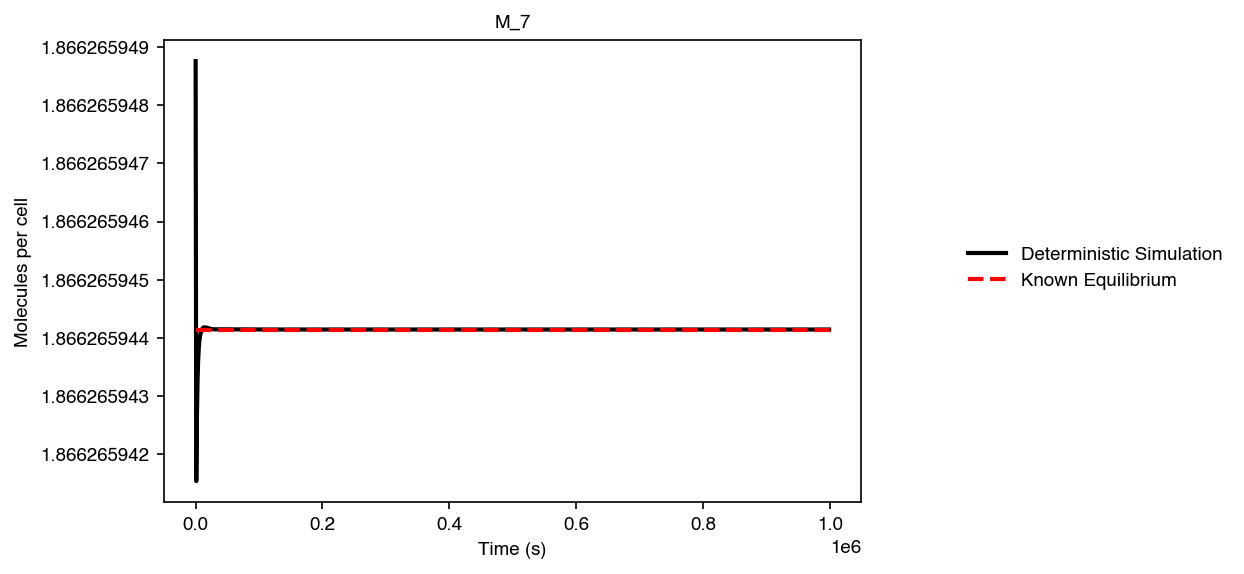

In [39]:
fig, ax = plt.subplots()

plot_every = timepoints.shape[0]//points_to_plot
_ = ax.plot(timepoints[::plot_every],solved_kinetics[species_to_plot,::plot_every],marker='',lw=2,linestyle='-',color='k')

_ = ax.hlines(xmin=timepoints[0],xmax=timepoints[-1],y=eq_concs[species_to_plot],lw=2,linestyle='--',color='r')

_ = ax.set_xlabel('Time (s)')
_ = ax.set_ylabel(f'Molecules per cell')
_ = ax.set_title(f'{make_nXn_species_names(m)[species_to_plot]}')

ax.get_yaxis().get_major_formatter().set_useOffset(False)

# Create Legend
patches = {}
patches['simulation'] = mlines.Line2D([],[],linestyle='-',linewidth=2,color='k', label='Deterministic Simulation')
patches['equilibrium'] = mlines.Line2D([],[],linestyle='--',linewidth=2,color='r', label='Known Equilibrium')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

## Analyze time to equilibrium

In [ ]:
timepoints_out_of_equilibrium = []
# Measure timepoints when >1 molecule out of equilibrium, deterministically
for species in range(m+num_combos_with_replacement(m,2)):
    where_non_eq = np.where(np.abs(eq_concs[species]-\
                                           solved_kinetics[species])>1)[0]
    if len(where_non_eq)==0:
        timepoints_out_of_equilibrium.append([])
    else:
        timepoints_out_of_equilibrium.append([where_non_eq[0],where_non_eq[-1]])

In [ ]:
time_to_equilibrium = [timepoints[x[1]] if len(x)==2 else 0 for x in timepoints_out_of_equilibrium]

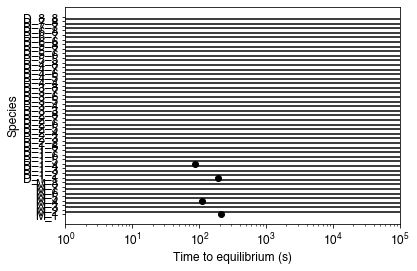

In [ ]:
fig, ax = plt.subplots()

_ = ax.plot(time_to_equilibrium,range(m+num_combos_with_replacement(m,2)),marker='.',\
            markersize=12,linestyle='',color='k')

_ = ax.hlines(xmin=timepoints[0],xmax=timepoints[-1],y=np.array(list(range(m+num_combos_with_replacement(m,2)-1)))+0.5,linestyle='-',color='k')

_ = ax.set_xlabel('Time to equilibrium (s)')
_ = ax.set_ylabel('Species')

_ = ax.set_xlim([timepoints[0]+1,timepoints[-1]])

_ = ax.set_xscale('log')

_ = ax.set_yticks(range(m+num_combos_with_replacement(m,2)),labels=make_nXn_species_names(m))

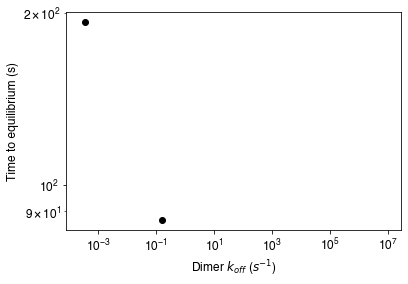

In [ ]:
fig, ax = plt.subplots()

_ = ax.plot(k_offs,time_to_equilibrium[m:],marker='.',\
            markersize=12,linestyle='',color='k')

_ = ax.set_ylabel('Time to equilibrium (s)')
_ = ax.set_xlabel(r'Dimer $k_{off}$ ($s^{-1}$)')

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')

## Screen Several Parameter Sets: Equilibration Time

In [ ]:
out_dir = str(pathlib.Path('/','home','ubuntu','Data','20230310_equilibration_time'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [ ]:
param_sets_per_m = 20

In [ ]:
default_time = 10000 # s
max_time = 10000000 # Due to memory limits

In [ ]:
vol_per_cell = 1e-12 # L
unitless_conc_per_molecule = 0.001

k_on = 5e5 # M-1 s-1
k_on_unitless = k_on/6.0221e23/vol_per_cell # molecule-1 s-1

In [ ]:
t = 30
input_lb = -3
input_ub = 3
x_points = np.logspace(input_lb,input_ub,t,endpoint=True)

In [ ]:
rng = np.random.default_rng()

In [ ]:
# This seems needed for numba/ray compatibility
# https://discuss.ray.io/t/ray-is-not-compatible-with-numba-cuda-when-import/1274/2
import sys
module_name = globals()['__name__']
current_module = sys.modules[module_name]

In [ ]:
def return_diff_eq_right_sides(current_species_amounts, t, k_on_unitless, k_offs,m,dimers):
    derivatives = []
    for monomer in range(m):
        dimers_with_monomer = [dimer for dimer,monomers in enumerate(dimers) if monomer in monomers]
        stoichiometry=[2 if np.all(np.array(dimers[dimer_i])==monomer) else 1 for dimer_i in dimers_with_monomer]
        derivatives.append(np.sum([(k_offs[dimer]*current_species_amounts[m+dimer]*stoichiometry[i])-\
                                   (k_on_unitless*current_species_amounts[dimers[dimer][0]]*current_species_amounts[dimers[dimer][1]]*stoichiometry[i])\
                                    for i,dimer in enumerate(dimers_with_monomer)]))
    for dimer,monomers in enumerate(dimers):
        derivatives.append((k_on_unitless*current_species_amounts[monomers[0]]*current_species_amounts[monomers[1]])-\
                           (k_offs[dimer]*current_species_amounts[m+dimer]))
    return derivatives

In [ ]:
def check_equilibrium(solved_kinetics,eq_concs,tolerance,tolerance_type='abs'):
    '''
    Function to check whether all dimers are at equilibrium following a numerical ODE integration.

    Inputs:
    -------
    solved_kinetics: np.array, shape (m+num_combos_with_replacement(m,2),len(timepoints))
        Array of concentrations of all species over time, as solved by scipy.integrate.odeint
    eq_concs: np.array, shape (m+num_combos_with_replacement(m,2),)
        Array of equilibrium concentrations of all species, as solved by simulate_networks_manual
    tolerance_type: str, 'abs' or 'rel' (default 'abs')
        If 'abs': tolerance is the maximum absolute difference between the known equilibrium value and the numerical solution
        If 'rel': tolerance is the maximum ratio between the known equilibrium value and the numerical solution. 
            For example, tolerance=0.1 if all species must be within 10% of the equilibrium value.
    
    Returns:
    --------
    bool: True if all species are within tolerance of the equilibrium value
    '''
    if tolerance_type=='abs':
        return np.all([np.abs(eq_concs[species]-solved_kinetics[species,-1])<=tolerance \
                       for species in range(m+num_combos_with_replacement(m,2))])
    elif tolerance_type=='rel':
        max_allowed_ratio = 1+tolerance
        min_allowed_ratio = max(0,1-tolerance)
        return np.all([(((np.abs(eq_concs[species]-solved_kinetics[species,-1])/eq_concs[species])<=max_allowed_ratio) and\
                        ((np.abs(eq_concs[species]-solved_kinetics[species,-1])/eq_concs[species])>=min_allowed_ratio))\
                       for species in range(m+num_combos_with_replacement(m,2))])

In [ ]:
@ray.remote
def ray_analyze_equilibration_time(m,m_i):
    sys.modules[module_name] = current_module
    time1 = time.time()
    
    k_offs_by_pset_by_species = []
    time_to_equilibrium_by_pset_by_species = []
    reports = []
    
    edge_key = {}
    homo_edges = []
    hetero_edges = []

    for i,combo in enumerate(itertools.combinations_with_replacement(range(m),r=2)):
        edge_key[(combo[0],combo[1])] = i
        if combo[0]==combo[1]:
            homo_edges.append(i)
        else:
            hetero_edges.append(i)
    
    min_edges = m - 1
    max_edges = num_combos(m,2)
    num_possible_num_edges = max_edges - min_edges + 1
    possible_num_edges = list(range(min_edges,max_edges+1))
    num_edges_to_test = np.array(possible_num_edges)[np.array([round(x) for x in np.linspace(0,num_possible_num_edges-1,param_sets_per_m)])]
    
    null_K = 1e-10
    K_log_range = [-3,1]
    A_log_range = [-3,3]
    null_K=1e-10
    null_K_homo_fraction=0.25
    
    param_sets = np.concatenate((np.full((param_sets_per_m,num_combos_with_replacement(m,r=2)),null_K),np.ones((param_sets_per_m,m-1))),axis=1)
    
    t = 30
    input_lb = -3
    input_ub = 3
    S_all = np.zeros((t,num_combos_with_replacement(m,2)+m,param_sets_per_m))
    
    for param_set_i, num_edges in enumerate(num_edges_to_test):
        report = f"\tParameter set {param_set_i}\n"
        report+= f"\t\tTime since start: {str(datetime.timedelta(seconds=round(time.time()-t1,0)))}\n"
        
        param_set = param_sets[param_set_i]
        graph = nx.gnm_random_graph(n=m,m=num_edges)
        if num_edges<=math.comb(m-1,2):
            # If false, graph is always connected
            while not nx.is_connected(graph):
                graph = nx.gnm_random_graph(n=m,m=num_edges)
        edge_indices = [edge_key[x] for x in graph.edges]
        # Fill heterodimer K's
        param_set[edge_indices] = 10**rng.uniform(K_log_range[0],K_log_range[1],size=(num_edges,))
        # Fill homodimer K's
        homo_edges_tofill = rng.choice(homo_edges,size=(round((1-null_K_homo_fraction)*m),),replace=False)
        param_set[homo_edges_tofill] = 10**rng.uniform(K_log_range[0],K_log_range[1],size=homo_edges_tofill.shape)
        # Fill A's
        param_set[-(m-1):] = 10**rng.uniform(A_log_range[0],A_log_range[1],size=(m-1,))
        
        param_sets[param_set_i] = param_set
        
        C0, S_all_temp = simulate_networks_manual(m, num_inputs=1, param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = -3, input_ub = 3)
        S_all[:,:,param_set_i] = S_all_temp[:,:,0]

        K = param_sets[param_set_i,:num_combos_with_replacement(m,2)]
        K_molec = K*unitless_conc_per_molecule # molecule-1
        k_offs = k_on_unitless/K_molec # s-1

        # Define initial concentrations
        initial_equilibrium_species_concs = S_all_temp[0,:,0] # Dimensionless
        initial_equilibrium_species_concs_molec = initial_equilibrium_species_concs/unitless_conc_per_molecule # molecule/cell

        # Then re-adjust input concentration
        initial_equilibrium_species_concs_molec[0] = x_points[-1]/unitless_conc_per_molecule

        
        timepoints = np.linspace(0, default_time, default_time//10, endpoint=True)

        dimers = np.array(list(itertools.combinations_with_replacement(range(m),2)))

        report+="\t\tSolving ODE kinetics\n"
        solved_kinetics = scipy.integrate.odeint(func=return_diff_eq_right_sides, y0=initial_equilibrium_species_concs_molec, t=timepoints,\
                                args = (k_on_unitless,k_offs,m,dimers)).transpose()
        eq_concs = eqtk.solve(c0=initial_equilibrium_species_concs_molec*unitless_conc_per_molecule, \
                              N=make_nXn_stoich_matrix(m), K=param_set[:num_combos_with_replacement(m,2)])
        eq_concs = eq_concs/unitless_conc_per_molecule
        success = check_equilibrium(solved_kinetics=solved_kinetics,eq_concs=eq_concs,\
                  tolerance=1,tolerance_type='abs')
        time_len_temp = default_time
        while (not success) and (time_len_temp<=max_time/10):
            report+=f"\t\t\tIncreasing timepoints from {time_len_temp} to {time_len_temp*10}\n"
            del solved_kinetics
            time_len_temp = time_len_temp*10
            timepoints = np.linspace(0, time_len_temp, time_len_temp//10, endpoint=True)
            solved_kinetics = scipy.integrate.odeint(func=return_diff_eq_right_sides, y0=initial_equilibrium_species_concs_molec, t=timepoints,\
                                args = (k_on_unitless,k_offs,m,dimers)).transpose()
            success = check_equilibrium(solved_kinetics=solved_kinetics,eq_concs=eq_concs,\
                      tolerance=1,tolerance_type='abs')
        if not success:
            report+=f'\t\t\tWARNING: m={m} parameter set {param_set_i} could not be simulated within {max_time} s\n'
        report+="\t\tProcessing Deterministic Data\n"
        time_to_equilibrium = []
        success_byspecies = np.array([np.abs(eq_concs[species]-solved_kinetics[species,-1])<1 \
                       for species in range(m+num_combos_with_replacement(m,2))])
        for species in range(m+num_combos_with_replacement(m,2)):
            if not success_byspecies[species]:
                time_to_equilibrium.append(time_len_temp)
            else:
                where_non_eq = np.where(np.abs(eq_concs[species]-\
                                                       solved_kinetics[species])>1)[0]
                if len(where_non_eq)==0:
                    time_to_equilibrium.append(0)
                else:
                    time_to_equilibrium.append(timepoints[where_non_eq[-1]])
    
        report+= f"\t\tTime since start: {str(datetime.timedelta(seconds=round(time.time()-t1,0)))}\n"

        k_offs_by_pset_by_species.append(k_offs)
        
        time_to_equilibrium_by_pset_by_species.append(time_to_equilibrium)

        reports.append(report)

        reports_sorted = list(sorted(reports,key=lambda x: int(''.join([c for c in x[:18] if c.isnumeric()]))))
        
        
        del solved_kinetics
    
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
    if not os.path.isdir(specific_out_dir):
        os.mkdir(specific_out_dir)
    np.save(str(pathlib.Path(specific_out_dir,f'param_sets.npy')),param_sets)
    np.save(str(pathlib.Path(specific_out_dir,f'S_all.npy')),S_all)
    np.save(str(pathlib.Path(specific_out_dir,f'num_edges_to_test.npy')),num_edges_to_test)
    np.save(str(pathlib.Path(specific_out_dir,f'k_offs_by_pset_by_species.npy')),k_offs_by_pset_by_species)
    np.save(str(pathlib.Path(specific_out_dir,f'time_to_equilibrium_by_pset_by_species.npy')),time_to_equilibrium_by_pset_by_species)
    np.save(str(pathlib.Path(specific_out_dir,f'equilibration_time_reports.npy')),reports_sorted)
    
    print(f"Finished m={m}")
    
    return

In [ ]:
futures = []
t1 = time.time()
for m in m_list:
    m_i = m_list.index(m)
    futures.append(ray_analyze_equilibration_time.remote(m,m_i))

results = []
for future in futures:
    results.append(ray.get(future))

(ray_analyze_equilibration_time pid=34114) Finished m=2
(ray_analyze_equilibration_time pid=34118) Finished m=3
(ray_analyze_equilibration_time pid=34116) Finished m=4
(ray_analyze_equilibration_time pid=34112) Finished m=5
(ray_analyze_equilibration_time pid=34131) Finished m=6
(ray_analyze_equilibration_time pid=34128) Finished m=7
(ray_analyze_equilibration_time pid=34113) Finished m=8
(ray_analyze_equilibration_time pid=34129) Finished m=9
(ray_analyze_equilibration_time pid=34115) Finished m=10
(ray_analyze_equilibration_time pid=34124) Finished m=11
(ray_analyze_equilibration_time pid=34130) Finished m=12


## Plots

In [ ]:
m_list = list(range(2,13)) # Network sizes to test

In [ ]:
t = 30 # Number of input points simulated
input_lb = -3 # Lower bound of input concentrations, in log space
input_ub = 3 # Upper bound of input concentrations, in log space
x_points = np.logspace(input_lb,input_ub,t,endpoint=True) # Input concentrations

In [ ]:
param_sets_per_m = 20 # Number of parameter sets to test for each network size

In [ ]:
default_time = 10000 # s, total time to simulate for deterministic simulations
max_time = 10000000 # Due to memory limits

In [ ]:
vol_per_cell = 1e-12 # L, estimated for mammalian cell
unitless_conc_per_molecule = 0.001

k_on = 5e5 # M-1 s-1
k_on_unitless = k_on/6.0221e23/vol_per_cell # molecule-1 s-1

In [ ]:
rng = np.random.default_rng()

In [ ]:
def moving_average(x_vals, y_vals, window_size=None, num_windows=50):
    if window_size is None:
        x_range = np.max(x_vals) - np.min(x_vals)
        window_size = x_range/5
    x_window_centers = np.linspace(np.min(x_vals),np.max(x_vals),\
                                   num_windows,endpoint=True)
    x_window_means = [(x, np.mean(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])) \
                        if len(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])>0\
                        else (x, np.nan) \
                        for x, window in zip(x_window_centers,range(num_windows))]
    return np.array(x_window_means)

In [ ]:
out_dir = str(pathlib.Path('/','home','ubuntu','Data','20230310_equilibration_time'))

Load data:

In [ ]:
input_i_at_eq = 29 # We simulated equilibration from input_i = 0 to input_i = 29

param_sets_by_m = []
S_all_by_m = []
num_edges_to_test_by_m = []
k_offs_by_m_by_pset_by_species = []
time_to_equilibrium_by_m_by_pset_by_species = [] 

for m in m_list:
    m_i = m_list.index(m)
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M'))
    param_sets_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'param_sets.npy')),allow_pickle=True))
    S_all_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'S_all.npy')),allow_pickle=True))
    num_edges_to_test_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'num_edges_to_test.npy')),allow_pickle=True))
    k_offs_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'k_offs_by_pset_by_species.npy')),allow_pickle=True))
    time_to_equilibrium_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'time_to_equilibrium_by_pset_by_species.npy')),allow_pickle=True))

Time to equilibrium histogram:

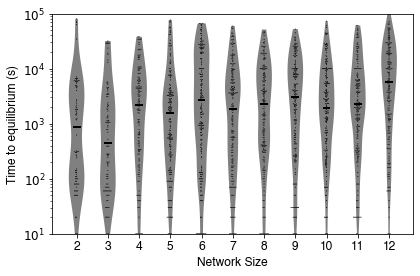

In [ ]:
fig, ax = plt.subplots()

max_time_obs = 10**math.ceil(np.log10(np.max(list(itertools.chain.from_iterable(itertools.chain.from_iterable(time_to_equilibrium_by_m_by_pset_by_species))))))

time_to_equilibrium_by_m = []
for m in m_list:
    m_i = m_list.index(m)
    time_to_equilibrium = np.array(list(itertools.chain.from_iterable(time_to_equilibrium_by_m_by_pset_by_species[m_i][param_set_i] for param_set_i in range(param_sets_per_m))))
    time_to_equilibrium = time_to_equilibrium[np.where(time_to_equilibrium>0)]
    time_to_equilibrium_by_m.append(np.log10(time_to_equilibrium))

parts = ax.violinplot(positions = m_list,\
           dataset = time_to_equilibrium_by_m,\
          #  labels = [str(m) for m in m_list],\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)
parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

subsample = 200
size = 1
for m,points in zip(m_list,time_to_equilibrium_by_m):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

log_min_y = 1
log_max_y = 5
ax.set_ylim([log_min_y,log_max_y])
ax.set_yticks(range(log_min_y,log_max_y+1),labels=['$10^{{{}}}$'.format(x) for x in range(log_min_y,log_max_y+1)],minor=False)
ax.set_yticks(list(itertools.chain.from_iterable([[np.log10((10**x)*y) for y in np.arange(2,10)] \
            for x in range(log_min_y,log_max_y)])),minor=True)
ax.set_xticks(m_list)
_ = ax.set_ylabel('Time to equilibrium (s)')
_ = ax.set_xlabel('Network Size')

filename = f'time_to_eq_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Time to equilibrium histogram, excluding zero-abundance (at equilibrium) species

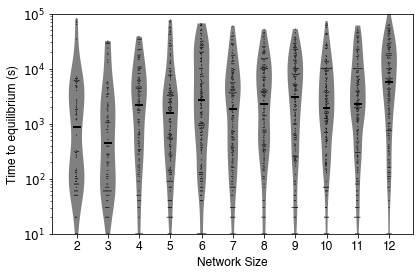

In [ ]:
fig, ax = plt.subplots()

time_to_equilibrium_by_m = []
for m in m_list:
    m_i = m_list.index(m)
    S_all = S_all_by_m[m_i]
    S_all[np.where(S_all<1e-3)] = 1e-3
    time_to_equilibrium_all = []
    for param_set_i in range(param_sets_per_m):
        eq_concs = S_all[input_i_at_eq,:,param_set_i]/unitless_conc_per_molecule
        time_to_equilibrium = np.array(time_to_equilibrium_by_m_by_pset_by_species[m_i][param_set_i])
        time_to_equilibrium_all+=list(time_to_equilibrium[np.where(eq_concs>=1)])
    time_to_equilibrium_all = np.array(time_to_equilibrium_all)
    time_to_equilibrium_all = time_to_equilibrium_all[np.where(time_to_equilibrium_all>0)]
    time_to_equilibrium_by_m.append(np.log10(time_to_equilibrium_all))
    

parts = ax.violinplot(positions = m_list,\
           dataset = time_to_equilibrium_by_m,\
          #  labels = [str(m) for m in m_list],\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)
parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

subsample = 200
size = 1
for m,points in zip(m_list,time_to_equilibrium_by_m):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

log_min_y = 1
log_max_y = 5
ax.set_ylim([log_min_y,log_max_y])
ax.set_yticks(range(log_min_y,log_max_y+1),labels=['$10^{{{}}}$'.format(x) for x in range(log_min_y,log_max_y+1)],minor=False)
ax.set_yticks(list(itertools.chain.from_iterable([[np.log10((10**x)*y) for y in np.arange(2,10)] \
            for x in range(log_min_y,log_max_y)])),minor=True)

ax.set_xticks(m_list)
_ = ax.set_ylabel('Time to equilibrium (s)')
_ = ax.set_xlabel('Network Size')

filename = f'time_to_eq_by_network_size_nonzero_species'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Time to equilibrium histogram, by connectivity:

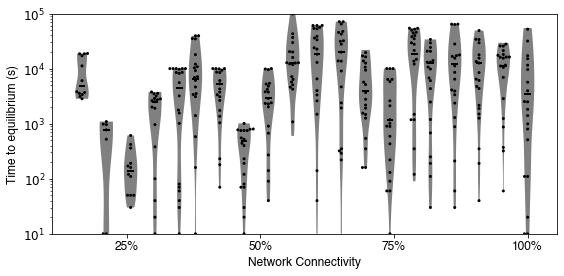

In [ ]:
m = 12
m_i = m_list.index(m)

fig, ax = plt.subplots(figsize=(8,4))

time_to_equilibrium_by_num_edges = []
unique_num_edges = np.sort(np.unique(num_edges_to_test_by_m[m_i]))
connectivities = unique_num_edges/num_combos(m,2)
for num_edges_i,num_edges in enumerate(unique_num_edges):
    time_to_equilibrium = []
    for param_set_i in np.where(num_edges_to_test_by_m[m_i]==num_edges)[0]:
        time_to_equilibrium+=list(time_to_equilibrium_by_m_by_pset_by_species[m_i][param_set_i])
    time_to_equilibrium = np.array(time_to_equilibrium)
    time_to_equilibrium = time_to_equilibrium[np.where(time_to_equilibrium>0)]
    time_to_equilibrium_by_num_edges.append(np.log10(time_to_equilibrium))
    

parts = ax.violinplot(positions = connectivities,\
           dataset = time_to_equilibrium_by_num_edges,\
          #  labels = [str(m) for m in m_list],\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
            widths = 0.025,
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)
parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

subsample = 20
size = 3
for connectivity,points in zip(connectivities,time_to_equilibrium_by_num_edges):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),connectivity),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

log_min_y = 1
log_max_y = 5
ax.set_ylim([log_min_y,log_max_y])
ax.set_yticks(range(log_min_y,log_max_y+1),labels=['$10^{{{}}}$'.format(x) for x in range(log_min_y,log_max_y+1)],minor=False)
ax.set_yticks(list(itertools.chain.from_iterable([[np.log10((10**x)*y) for y in np.arange(2,10)] \
            for x in range(log_min_y,log_max_y)])),minor=True)

_ = ax.set_xticks(np.linspace(0,1,5,endpoint=True))
_ = ax.set_xticklabels([f'{x:.0%}' for x in np.linspace(0,1,5,endpoint=True)])

_ = ax.set_ylabel('Time to equilibrium (s)')
_ = ax.set_xlabel('Network Connectivity')

filename = f'{m}M_time_to_eq_by_network_connectivity'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Time to equilibrium histogram, excluding zero-abundance (at equilibrium) species, by connectivity:

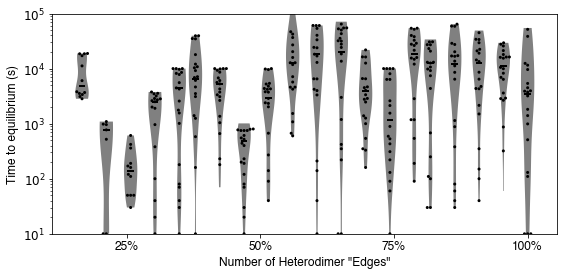

In [ ]:
m = 12
m_i = m_list.index(m)

fig, ax = plt.subplots(figsize=(8,4))

S_all = S_all_by_m[m_i]
S_all[np.where(S_all<1e-3)] = 1e-3

time_to_equilibrium_by_num_edges = []
unique_num_edges = np.unique(num_edges_to_test_by_m[m_i])
connectivities = unique_num_edges/num_combos(m,2)
for num_edges_i,num_edges in enumerate(unique_num_edges):
    time_to_equilibrium_all = []
    for param_set_i in np.where(num_edges_to_test_by_m[m_i]==num_edges)[0]:
        eq_concs = S_all[input_i_at_eq,:,param_set_i]/unitless_conc_per_molecule
        time_to_equilibrium = np.array(time_to_equilibrium_by_m_by_pset_by_species[m_i][param_set_i])
        time_to_equilibrium_all+=list(time_to_equilibrium[np.where(eq_concs>=1)])
    time_to_equilibrium_all = np.array(time_to_equilibrium_all)
    time_to_equilibrium_all = time_to_equilibrium_all[np.where(time_to_equilibrium_all>0)]
    time_to_equilibrium_by_num_edges.append(np.log10(time_to_equilibrium_all))
    

parts = ax.violinplot(positions = connectivities,\
           dataset = time_to_equilibrium_by_num_edges,\
          #  labels = [str(m) for m in m_list],\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
            widths = 0.025,
)
for face in parts['bodies']:
    face.set_facecolor('gray')
    face.set_alpha(1)
parts['cmedians'].set_color('k')
parts['cmedians'].set_linewidth(2)

subsample = 20
size = 3
for connectivity,points in zip(connectivities,time_to_equilibrium_by_num_edges):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),connectivity),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

log_min_y = 1
log_max_y = 5
ax.set_ylim([log_min_y,log_max_y])
ax.set_yticks(range(log_min_y,log_max_y+1),labels=['$10^{{{}}}$'.format(x) for x in range(log_min_y,log_max_y+1)],minor=False)
ax.set_yticks(list(itertools.chain.from_iterable([[np.log10((10**x)*y) for y in np.arange(2,10)] \
            for x in range(log_min_y,log_max_y)])),minor=True)

_ = ax.set_xticks(np.linspace(0,1,5,endpoint=True))
_ = ax.set_xticklabels([f'{x:.0%}' for x in np.linspace(0,1,5,endpoint=True)])

_ = ax.set_ylabel('Time to equilibrium (s)')
_ = ax.set_xlabel('Number of Heterodimer "Edges"')

filename = f'{m}M_time_to_eq_by_network_connectivity_nonzero_species'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Time to equilibrium vs. abundance:

Working on m=2
Working on m=3
Working on m=4
Working on m=5
Working on m=6
Working on m=7
Working on m=8
Working on m=9
Working on m=10
Working on m=11
Working on m=12


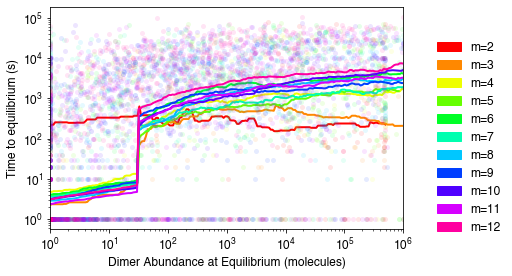

In [ ]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('hsv')

for m in m_list:
    print(f"Working on m={m}")
    m_i = m_list.index(m)
    S_all = S_all_by_m[m_i]
    S_all[np.where(S_all<1e-3)] = 1e-3
    all_x_data = []
    all_y_data = []
    for param_set_i in range(param_sets_per_m):
        time_to_equilibrium = np.array(time_to_equilibrium_by_m_by_pset_by_species[m_i][param_set_i])
        time_to_equilibrium[np.where(time_to_equilibrium==0)] = 1
        all_x_data += list(S_all[input_i_at_eq,:,param_set_i]/unitless_conc_per_molecule)
        all_y_data += list(time_to_equilibrium)
        _ = ax.plot(S_all[input_i_at_eq,:,param_set_i]/unitless_conc_per_molecule,time_to_equilibrium,marker='.',\
                    markersize=10,linestyle='',color=cmap(m_i/len(m_list)),alpha=0.1,markeredgewidth=0)
    x_window_means = moving_average(x_vals=np.log10(all_x_data), y_vals=np.log10(all_y_data), \
                                                      window_size=3, num_windows=200)
    _ = ax.plot(10**x_window_means[:,0],10**x_window_means[:,1],linestyle='-',marker='',color=cmap(m_i/len(m_list)),alpha=1,lw=2)

_ = ax.set_ylabel('Time to equilibrium (s)')
_ = ax.set_xlabel(r'Dimer Abundance at Equilibrium (molecules)')

# _ = ax.hlines(y=max_time,xmin=10**min_log_abundance,xmax=10**max_log_abundance,colors='k',linestyle='-')

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlim([10**0,10**6])

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'time_to_eq_vs_abdaunce_by_network_size_movingavg'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

Time to equilibrium vs. koff:

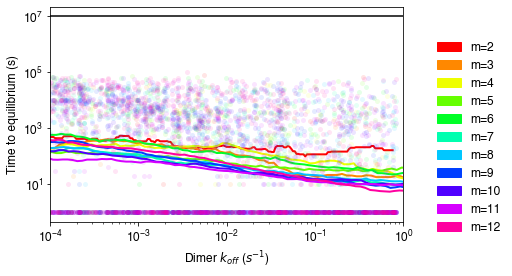

In [ ]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('hsv')

for m in m_list:
    m_i = m_list.index(m)
    all_x_data = []
    all_y_data = []
    for param_set_i in range(param_sets_per_m):
        k_offs = k_offs_by_m_by_pset_by_species[m_i][param_set_i]
        time_to_equilibrium = np.array(time_to_equilibrium_by_m_by_pset_by_species[m_i][param_set_i][m:])
        time_to_equilibrium[np.where(time_to_equilibrium==0)] = 1
        all_x_data += list(k_offs)
        all_y_data += list(time_to_equilibrium)
        _ = ax.plot(k_offs,time_to_equilibrium,marker='.',\
                    markersize=10,linestyle='',color=cmap(m_i/len(m_list)),alpha=0.1,markeredgewidth=0)
    x_window_means = moving_average(x_vals=np.log10(all_x_data), y_vals=np.log10(all_y_data), \
                                                      window_size=2, num_windows=200)
    _ = ax.plot(10**x_window_means[:,0],10**x_window_means[:,1],linestyle='-',marker='',color=cmap(m_i/len(m_list)),alpha=1,lw=2)

_ = ax.set_ylabel('Time to equilibrium (s)')
_ = ax.set_xlabel(r'Dimer $k_{off}$ ($s^{-1}$)')

min_koff = 1e-4
max_koff = 1e0

_ = ax.hlines(y=max_time,xmin=min_koff,xmax=max_koff,colors='k',linestyle='-')

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlim([min_koff,max_koff])

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

filename = f'time_to_eq_vs_koff_by_network_size_movingavg'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')